# Imports 

In [80]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt


# Processing

### Processing portfolio.csv

In [104]:
# creating dummies so that if I want, later I can change my prediction labels from offer_id to other attributes like reward, difficulty, or predict channels_
portfolio = pd.read_csv("portfolio.csv").drop("Unnamed: 0", axis=1)
# having universal names
portfolio.rename({"id": "offer_id"}, axis=1, inplace=True)
pd.get_dummies(portfolio)
d_portfolio = pd.get_dummies(portfolio[portfolio.columns[:5]])
d_portfolio["offer_id"] = portfolio["offer_id"]
d_portfolio.head()

,reward,difficulty,duration,"channels_['email', 'mobile', 'social']","channels_['web', 'email', 'mobile', 'social']","channels_['web', 'email', 'mobile']","channels_['web', 'email']",offer_type_bogo,offer_type_discount,offer_type_informational,offer_id
0,10,10,7,True,False,False,False,True,False,False,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,5,False,True,False,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,4,False,False,True,False,False,False,True,3f207df678b143eea3cee63160fa8bed
3,5,5,7,False,False,True,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,10,False,False,False,True,False,True,False,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Processing profile.csv

In [71]:
profile = pd.read_csv("profile.csv").drop("Unnamed: 0", axis=1)

# having universal names
profile.rename({"id": "person"}, axis=1, inplace=True)

# removing age=118, considering it an outlier 
profile["age"] = profile["age"].replace(118, np.nan)

# Either all 3 attributed (income, gender, age) are present, or all 3 are absent together 
print("Times all 3 attributes are absent together:", ((profile["income"].isna() == profile["gender"].isna()) == (profile["age"].isna() == profile["gender"].isna())).mean())
print("Ratio of records where these 3 attributes are empty: ", profile["income"].isna().sum()/len(profile))

# Not including those users for now, adding an approach later to include them (not implemented)
profile = profile[profile["income"].notna()]


# I notice that different users have different date of joining and different incomes, and incomes usually increase every year 
# We Need to calculate how much all these users would be making today, or on the latest date in the dataset
# Also creating a new feature, days_diff, showing how long a user has been in the dataset
# If i wanted to do imputatiion by mean or median, it'd be more accurate now 
# assuming growth rate of 8% PA

annual_growth_rate = 0.08
daily_growth_rate = (1 + annual_growth_rate) ** (1/365) 

profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], format="%Y%m%d")
profile['days_diff'] = (profile["became_member_on"].max() - profile['became_member_on']).dt.days
profile["max_date_income"] = profile["income"] * (daily_growth_rate) ** profile['days_diff']
profile.drop(["income"], axis=1, inplace=True)
profile["days_diff"] = profile["days_diff"] 


Times all 3 attributes are absent together: 1.0
Ratio of records where these 3 attributes are empty:  0.12794117647058822


### Processing transcript.csv

In [72]:
transcript = pd.read_csv("transcript.csv").drop("Unnamed: 0", axis=1)

# converting string to dict
transcript["value"] = transcript["value"].apply(lambda x: ast.literal_eval(x))

In [73]:
# Should've used df.apply with list flattening
# There are some entries where the dict in the value column has multiple values 
# Each key gets its own column for better clarity
# I also notice that one single user has multiple entries

new_transcript = []
for idx,i in transcript.iterrows():
    for key,value in i.value.items():
        new_i = i.copy()
        if key=="offer id":
            key="offer_id"
        
        new_i[key] = value
        new_i.value = key
        new_transcript += [new_i]
        
new_transcript = pd.DataFrame(new_transcript)
new_transcript.to_csv("new_transcript.csv", index=None)


In [101]:
new_transcript.head()

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,offer_id,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,offer_id,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,offer_id,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,offer_id,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,offer_id,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Aggregating

In [94]:
# Mergeing new_transcript above with profile to have user
# I can also merge with portfolio var above, if my target label needs to change from offer_id to something else
# I'll only need focus on offer_id
# Shouldn't have created d_portfolio
mix = new_transcript.merge(profile, "inner", "person")

# I'll keep duplicates for now, can't be sure if these are added accidentally or are valid
# Can be an edge case where a user has been accidentally given the same offer/value twice, could do more analysis on this
# Do we want this to happen?
print("Ratio of duplicate entries", (1 - len(mix.drop_duplicates())/len(mix)))

# mix.drop_duplicates(inplace=True)

Ratio of duplicate entries 0.004115253304325606


 Ratio of users that haven't gotten any offer_id value:  0.0003372681281618887
 Ratio of users that haven't gotten any amount value:  0.02246205733558179
 Ratio of users that haven't gotten any reward value:  0.1915008431703204


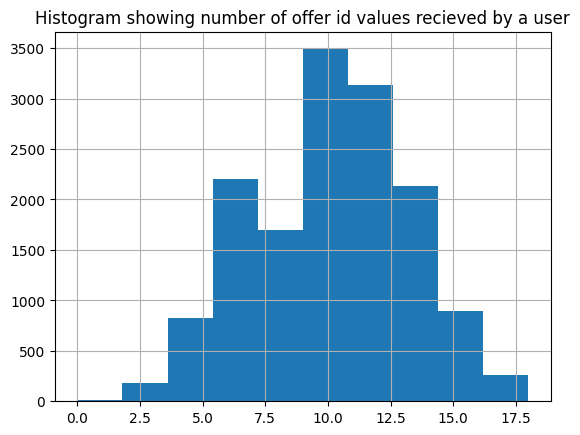

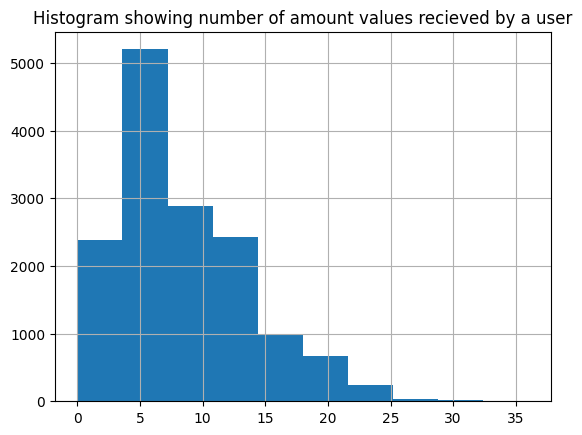

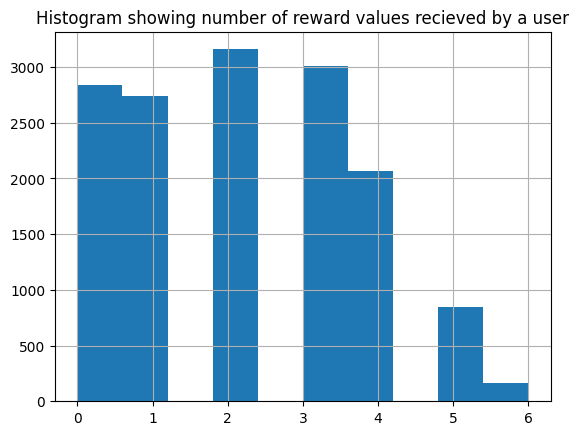

In [88]:
# getting all attributes for each user
transcript_grouped = mix.groupby("person")

# I can assume that every user would be getting atleast one offer_id and amount value (since the ratios are very low), hence I'll skip building models to find out if the user deserves these values or not
# Since 80% users have recieved a reward value, it makes sense to have a model that first predicts if a user should be given a reward value, 
#   and the next model can determine how many reward values a user requires, or I can integrate both into one Deep Learning Model
 

print(" Ratio of users that haven't gotten any offer_id value: ", (transcript_grouped["offer_id"].count()==0).sum()/len(profile))
print(" Ratio of users that haven't gotten any amount value: ", (transcript_grouped["amount"].count()==0).sum()/len(profile))
print(" Ratio of users that haven't gotten any reward value: ", (transcript_grouped["reward"].count()==0).sum()/len(profile))


ax = transcript_grouped["offer_id"].count().hist()
ax.set_title("Histogram showing number of offer id values recieved by a user")
plt.show()


ax = transcript_grouped["amount"].count().hist()
ax.set_title("Histogram showing number of amount values recieved by a user")
plt.show()


ax = transcript_grouped["reward"].count().hist()
ax.set_title("Histogram showing number of reward values recieved by a user")
plt.show()


# I create features that store mean and count of the values recieved by the users
# Can use these as input features or output labels, depends on the requirement


# I'll just ignore the event and time attributes originally from transcript (or new_transcript) since I think they come after an offer has been given to the user
# If they're important: 
#   For the time attribute, I can get time_mean 
#   If I have to use a simple ML model, I could also take time_count, or i could get offer_id_count + amount_count + reward_count    
#   For the event attribute, I could take the pivot table approach that I've done below for offer_ids

hoho = profile.set_index("person")
hoho["offer_id_count"] = transcript_grouped["offer_id"].count()
hoho["amount_count"] = transcript_grouped["amount"].count()
hoho["amount_mean"] = transcript_grouped["amount"].mean()
hoho["reward_count"] = transcript_grouped["reward"].count()
hoho["reward_mean"] = transcript_grouped["reward"].mean()

# Saving this dataset
new_profile = hoho.reset_index()
new_profile.to_csv("new_profile.csv", index=None)

In [102]:
new_profile.head()

,person,gender,age,became_member_on,days_diff,max_date_income,offer_id_count,amount_count,amount_mean,reward_count,reward_mean
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,376,121240.877064,3,3,25.670000,1,5.000000
1,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,443,109790.905326,11,7,22.752857,3,6.666667
2,e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,91,71356.096788,9,3,19.243333,2,3.500000
3,389bc3fa690240e798340f5a15918d5c,M,65.0,2018-02-09,167,54899.499150,17,3,12.143333,5,3.800000
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,2017-11-11,257,53839.889867,6,4,3.905000,1,2.000000


In [96]:
# Since I can't take an average of the offer_id value like I did with the amount and reward value
#   Let me create a table where each row is a unique user and each column is a unique offer_id from portfolio.csv, 
#   and each value is the number of times I see the offer_id and user together  

portfolio_profile = mix.pivot_table(index='person', columns='offer_id', aggfunc='size', fill_value=0)

# For simplicity, I'll convert this to binary for now, otherwise value being +ve integers is also fine. 
portfolio_profile = portfolio_profile.map(lambda x: 1 if x > 0 else 0)

# Adding proper prefixes to the user_ids
portfolio_profile.columns = ["xid-"+col for col in portfolio_profile.columns]

# moving person index to a column
portfolio_profile = portfolio_profile.reset_index()

In [97]:
# I can merge new_profile with attributes I created with this new portfolio_profile to get all my features
# I can afford inner join since i'll only lose 0.0003372681281618887 (ratioi got from above) entries
#    Else I could've just done mean/mediam/mode imputation
final_dataset = new_profile.merge(portfolio_profile, "inner", "person")

# Dropping unwanted columns for training 
final_dataset.drop(["person", "became_member_on"], axis=1, inplace=True)
final_dataset.to_csv("final_dataset.csv", index=None)
final_dataset

,gender,age,days_diff,max_date_income,offer_id_count,amount_count,amount_mean,reward_count,reward_mean,xid-0b1e1539f2cc45b7b9fa7c272da2e1d7,xid-2298d6c36e964ae4a3e7e9706d1fb8c2,xid-2906b810c7d4411798c6938adc9daaa5,xid-3f207df678b143eea3cee63160fa8bed,xid-4d5c57ea9a6940dd891ad53e9dbe8da0,xid-5a8bc65990b245e5a138643cd4eb9837,xid-9b98b8c7a33c4b65b9aebfe6a799e6d9,xid-ae264e3637204a6fb9bb56bc8210ddfd,xid-f19421c1d4aa40978ebb69ca19b0e20d,xid-fafdcd668e3743c1bb461111dcafc2a4
0,F,55.0,376,121240.877064,3,3,25.670000,1,5.000000,0,0,0,1,0,0,1,0,0,0
1,F,75.0,443,109790.905326,11,7,22.752857,3,6.666667,0,0,0,0,0,1,1,1,1,0
2,M,68.0,91,71356.096788,9,3,19.243333,2,3.500000,0,0,1,1,0,0,1,0,0,1
3,M,65.0,167,54899.499150,17,3,12.143333,5,3.800000,0,0,1,0,0,0,1,0,1,1
4,M,58.0,257,53839.889867,6,4,3.905000,1,2.000000,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,F,45.0,52,54595.330618,6,7,2.861429,0,NaN,0,1,0,0,1,1,0,0,0,0
14816,M,61.0,13,72197.628362,5,7,3.710000,1,5.000000,0,0,0,1,0,1,1,0,0,0
14817,M,49.0,546,81907.021894,4,8,4.967500,0,NaN,1,0,0,1,0,1,0,0,0,0
14818,F,83.0,871,60079.894011,9,14,13.547857,3,8.333333,0,0,0,0,1,0,1,1,0,0


In [105]:
print(final_dataset.columns)


Index(['gender', 'age', 'days_diff', 'max_date_income', 'offer_id_count',
       'amount_count', 'amount_mean', 'reward_count', 'reward_mean',
       'xid-0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'xid-2298d6c36e964ae4a3e7e9706d1fb8c2',
       'xid-2906b810c7d4411798c6938adc9daaa5',
       'xid-3f207df678b143eea3cee63160fa8bed',
       'xid-4d5c57ea9a6940dd891ad53e9dbe8da0',
       'xid-5a8bc65990b245e5a138643cd4eb9837',
       'xid-9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'xid-ae264e3637204a6fb9bb56bc8210ddfd',
       'xid-f19421c1d4aa40978ebb69ca19b0e20d',
       'xid-fafdcd668e3743c1bb461111dcafc2a4'],
      dtype='object')
